# Final Cleanup

In [28]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

In [29]:
# Adjust settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
%matplotlib inline

In [30]:
# Load preprocessed dataset

data_path = '../data/interim/'
df = pd.read_pickle(os.path.join(data_path, 'features.pkl'))

In [31]:
# Drop columns not needed for models
df.drop(columns=['flt_offblock', 'flt_onblock', 'flt_sched_dep', 'flt_sched_arr', 'cc_roles', 'sched_gt', 'act_gt'], inplace=True)

## Outlier identification

In [32]:
# Function to identify outliers for all continous variables
def find_outliers(df, col):
    q25 = df[col].quantile(0.25)
    q75 = df[col].quantile(0.75)
    iqr = q75 - q25
    ll = q25 - 1.5 * iqr
    ul = q75 + 1.5 * iqr

    ls = df.index[(df[col] < ll) | (df[col] > ul)]

    return ls

outlier_idx = []
for col in df.columns:
    if df[col].dtype in ['int64', 'float64']:
        outlier_idx.extend(find_outliers(df, col))

In [33]:
# Function to remove outliers from dataframe
def remove(df, ls):
    ls = sorted(set(ls))
    df = df.drop(ls)
    return df
    
df_cleaned = remove(df, outlier_idx)

In [34]:
print(df.shape)
print(df_cleaned.shape)

(11703, 19)
(8472, 19)


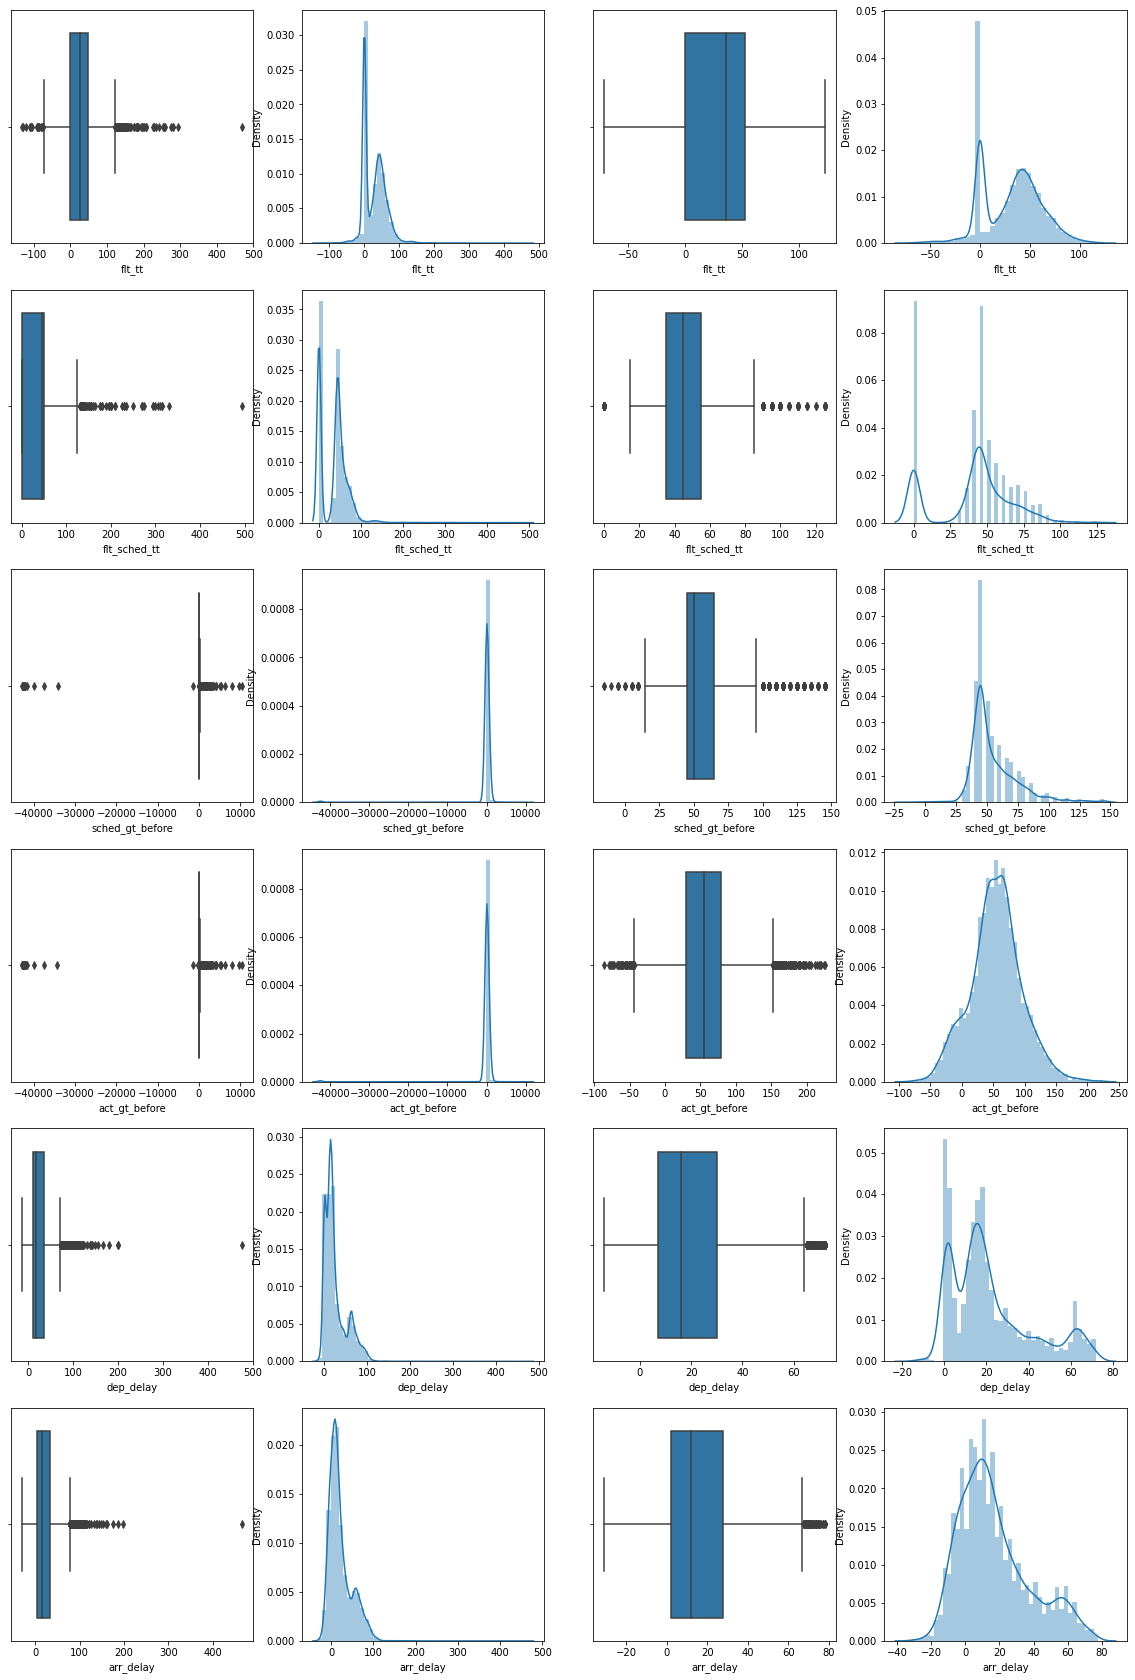

In [35]:
# Printing box- and distplots for cleaned and uncleaned data.

plt.figure(figsize=(20,30))

plt.subplot(6,4,1)
sns.boxplot(x=df['flt_tt'])
plt.subplot(6,4,2)
sns.distplot(df['flt_tt'])
plt.subplot(6,4,3)
sns.boxplot(x=df_cleaned['flt_tt'])
plt.subplot(6,4,4)
sns.distplot(df_cleaned['flt_tt'])

plt.subplot(6,4,5)
sns.boxplot(x=df['flt_sched_tt'])
plt.subplot(6,4,6)
sns.distplot(df['flt_sched_tt'])
plt.subplot(6,4,7)
sns.boxplot(x=df_cleaned['flt_sched_tt'])
plt.subplot(6,4,8)
sns.distplot(df_cleaned['flt_sched_tt'])

plt.subplot(6,4,9)
sns.boxplot(x=df['sched_gt_before'])
plt.subplot(6,4,10)
sns.distplot(df['sched_gt_before'])
plt.subplot(6,4,11)
sns.boxplot(x=df_cleaned['sched_gt_before'])
plt.subplot(6,4,12)
sns.distplot(df_cleaned['sched_gt_before'])

plt.subplot(6,4,13)
sns.boxplot(x=df['act_gt_before'])
plt.subplot(6,4,14)
sns.distplot(df['act_gt_before'])
plt.subplot(6,4,15)
sns.boxplot(x=df_cleaned['act_gt_before'])
plt.subplot(6,4,16)
sns.distplot(df_cleaned['act_gt_before'])

plt.subplot(6,4,17)
sns.boxplot(x=df['dep_delay'])
plt.subplot(6,4,18)
sns.distplot(df['dep_delay'])
plt.subplot(6,4,19)
sns.boxplot(x=df_cleaned['dep_delay'])
plt.subplot(6,4,20)
sns.distplot(df_cleaned['dep_delay'])

plt.subplot(6,4,21)
sns.boxplot(x=df['arr_delay'])
plt.subplot(6,4,22)
sns.distplot(df['arr_delay'])
plt.subplot(6,4,23)
sns.boxplot(x=df_cleaned['arr_delay'])
plt.subplot(6,4,24)
sns.distplot(df_cleaned['arr_delay'])

plt.show()

## Transition Time

In [36]:
# Describe flt_tt
df_cleaned['flt_tt'].describe()

count    8472.000000
mean       32.104934
std        28.323159
min       -71.000000
25%         0.000000
50%        36.000000
75%        52.000000
max       122.000000
Name: flt_tt, dtype: float64

## Scheduled Transition Time

In [37]:
# Describe flt_sched_tt
df_cleaned['flt_sched_tt'].describe()

count    8472.000000
mean       40.355288
std        25.762440
min         0.000000
25%        35.000000
50%        45.000000
75%        55.000000
max       125.000000
Name: flt_sched_tt, dtype: float64

## Scheduled Groundtime

In [38]:
# Describe sched_gt
df_cleaned['sched_gt_before'].describe()

count    8349.000000
mean       54.925740
std        18.810469
min       -15.000000
25%        45.000000
50%        50.000000
75%        65.000000
max       145.000000
Name: sched_gt_before, dtype: float64

In [39]:
# How many cases have a negative scheduled groundtime?
df_cleaned[(df_cleaned['sched_gt_before'] < 0)].shape

(7, 19)

In [40]:
# Delete cases with scheduled negative groundtime
df_cleaned = df_cleaned[(df_cleaned['sched_gt_before'] >= 0)]

## Actual Groundtime

In [41]:
# Describe act_gt
df_cleaned['act_gt_before'].describe()

count    8342.000000
mean       54.561856
std        41.458533
min       -86.000000
25%        30.000000
50%        55.000000
75%        79.000000
max       225.000000
Name: act_gt_before, dtype: float64

In [42]:
# How many cases have a negative actual groundtime?
df_cleaned[(df_cleaned['act_gt_before'] < 0)].shape

(863, 19)

In [43]:
# Delete cases with actual negative groundtime
df_cleaned = df_cleaned[(df_cleaned['act_gt_before'] >= 0)]

In [44]:
df_cleaned.shape

(7479, 19)

## Departure Delay

In [45]:
# Describe dep_delay
df_cleaned['dep_delay'].describe()

count    7479.000000
mean       23.060703
std        19.444218
min       -14.000000
25%        10.000000
50%        18.000000
75%        32.000000
max        72.000000
Name: dep_delay, dtype: float64

## Arrival Delay

In [46]:
# Describe arr_delay
df_cleaned['arr_delay'].describe()

count    7479.000000
mean       18.412488
std        20.947509
min       -31.000000
25%         3.000000
50%        14.000000
75%        30.000000
max        78.000000
Name: arr_delay, dtype: float64

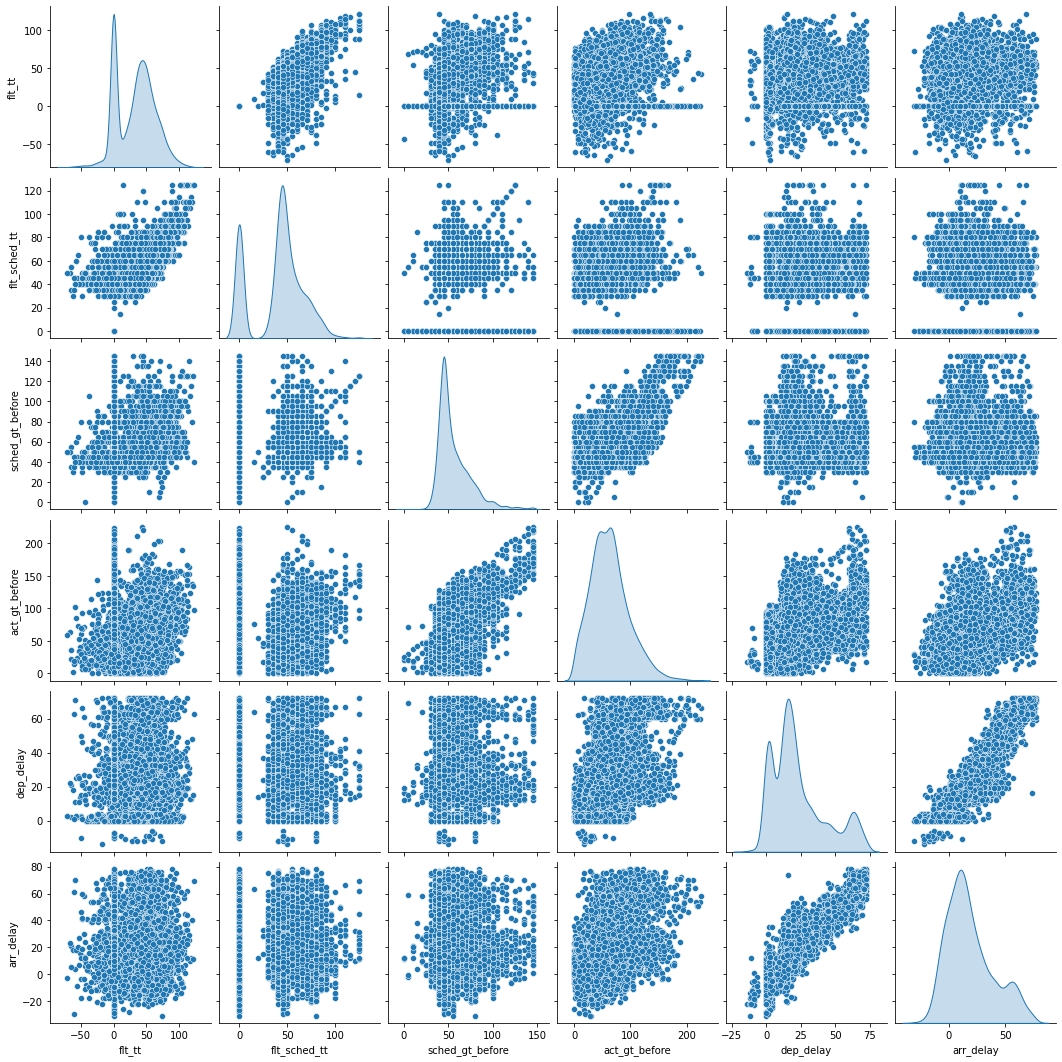

In [47]:
# Pairplot of all numerical values including dependent variable
data = df_cleaned[['flt_tt', 'flt_sched_tt', 'sched_gt_before', 'act_gt_before', 'dep_delay',  'arr_delay']]
sns.pairplot(df_cleaned, vars=data, diag_kind='kde')

<AxesSubplot:>

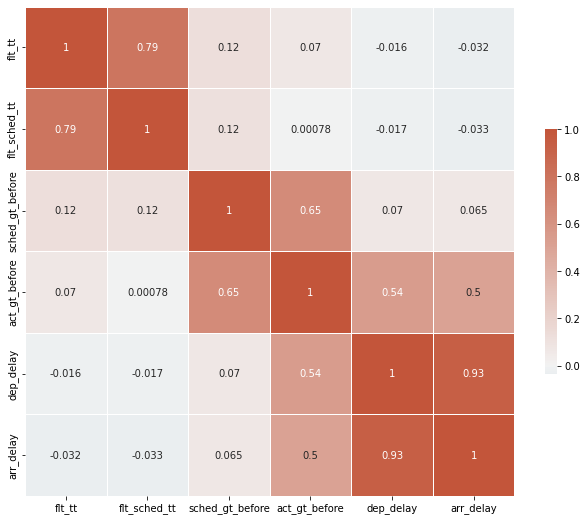

In [48]:
corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

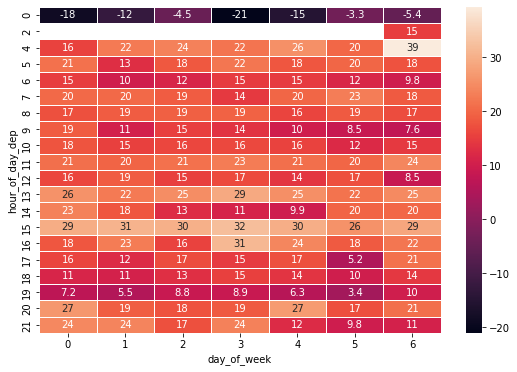

In [49]:
# Heatmap for day of week, hour of day and arr_delay
data = df_cleaned.pivot_table(index='hour_of_day_dep', columns='day_of_week', values='arr_delay', aggfunc=np.mean)
f, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(data, annot=True,linewidths=.5, ax=ax)

In [50]:
# Final check on NaN values
total = df_cleaned.isnull().sum().sort_values(ascending=False)
percent = (df_cleaned.isnull().sum()/df_cleaned.isnull().count().sort_values(ascending=False))
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(28)

,Total,Percent
gnd_mingt,1,0.000134
AC Type,1,0.000134
flt_ac_reg,0,0.000000
ca_count,0,0.000000
flight_of_day,0,0.000000
hour_of_day_arr,0,0.000000
hour_of_day_dep,0,0.000000
day_of_week,0,0.000000
cc_count,0,0.000000
cc_cp_ca,0,0.000000


In [51]:
# Drop the row with missing AC Type and mingt
df_cleaned.dropna(inplace=True)

In [52]:
# Final view on dataframe
df_cleaned.head()

,flt_ac_reg,dep_delay,flt_tt,flt_sched_tt,gnd_mingt,arr_delay,AC Type,routing,sched_gt_before,act_gt_before,cp_count,ca_count,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr,flight_of_day,cc_types
117,ECLBAX,15.0,60.0,60.0,45.0,6.0,321,East Carmen_South Nathaniel,95.0,94.0,2,4,both,6,5,8,10,2,3
194,ECLBAX,51.0,68.0,75.0,45.0,37.0,321,South Nathaniel_East Carmen,75.0,120.0,2,4,none,0,5,11,14,3,1
268,ECLBAX,43.0,64.0,70.0,45.0,32.0,321,East Carmen_Joneshaven,80.0,86.0,2,4,both,6,5,15,17,4,3
302,ECLBAX,14.0,42.0,50.0,45.0,4.0,321,Joneshaven_East Carmen,50.0,32.0,2,4,none,0,5,17,19,5,1
477,ECLBAX,15.0,39.0,45.0,45.0,8.0,321,Joneshaven_East Carmen,45.0,38.0,2,4,none,0,6,8,10,2,1


In [53]:
df_cleaned.describe()

,dep_delay,flt_tt,flt_sched_tt,arr_delay,sched_gt_before,act_gt_before
count,7478.000000,7478.000000,7478.000000,7478.000000,7478.000000,7478.000000
mean,23.063386,33.100695,40.726799,18.413881,56.273736,63.100695
std,19.444134,28.513498,26.475515,20.948564,19.140075,34.471285
min,-14.000000,-71.000000,0.000000,-31.000000,0.000000,0.000000
25%,10.000000,0.000000,30.000000,3.000000,45.000000,39.000000
50%,18.000000,37.000000,45.000000,14.000000,50.000000,60.000000
75%,32.000000,53.000000,55.000000,30.000000,65.000000,82.000000
max,72.000000,122.000000,125.000000,78.000000,145.000000,225.000000


In [54]:
convert_dict = {'gnd_mingt': 'int',
                'cp_count': 'int',
                'ca_count': 'int',
                'cc_count': 'int',
                'day_of_week': 'int',
                'hour_of_day_dep': 'int',
                'hour_of_day_arr': 'int',
                'flight_of_day': 'int',
                'cc_types': 'int'
}
df_cleaned = df_cleaned.astype(convert_dict)

In [55]:
df_cleaned.to_csv('../data/processed/final.csv')
df_cleaned.to_pickle('../data/processed/final.pkl')

In [56]:
# One-hot encode all catgorical variables
df_one_hot = pd.get_dummies(df_cleaned, drop_first=True)
df_one_hot.dropna(axis=0, how='any', inplace=True)

In [57]:
df_one_hot.to_csv('../data/processed/final_one_hot.csv')
df_one_hot.to_pickle('../data/processed/final_one_hot.pkl')